# Exploring Single Neuron Excitability with Mathematical and Computational Models Computer Lab 1
 ## Data, Feature extraction and Izhekevich models
##### Nils Koch and Niklas Brake

Overview of openly accessible electrophysiological data, feature extraction. Izhekevich model implementation and tuning by hand

# 1. Openly accessible electrophysiology repositories and accessing data

## Blue Brain Project

EPFL's Blue Brain Project is a Swiss brain research initiative aimed at establishing simulation euroscience as a complementary approach alongside experimental, theoretical and clinical neuroscience to understanding the brain, by building the world’s first biologically detailed digital reconstructions and simulations of the mouse brain.

Openly Accessible data available for download: [Neuronal-electrical data](https://portal.bluebrain.epfl.ch/resources/data/neuronal-electrical/)

Available models: [Blue Brain Project Models](https://portal.bluebrain.epfl.ch/resources/models/)

Available software: [Blue Brain Software Suites](https://portal.bluebrain.epfl.ch/resources/software/)

Resource for ion channel properties: [Channelpedia](https://channelpedia.epfl.ch/)

## Allen Brain Institute

The Allen Institute for Brain Science is focused on understanding the complexities of the brain by mapping its cells and cell types with unprecedented precision and scale.

Cell types, Atlases, Gene expression and more: [Allen Brain Map](https://portal.brain-map.org/)

Electrophysiology: DANDI Archive


## How do you use these datasets?

### 1. Download the data


### 2. The Distributed Archives for Neurophysiology Data Integration (DANDI) Archive
The BRAIN Initiative archive for publishing and sharing neurophysiology data including electrophysiology, optophysiology, and behavioral time-series, and images from immunostaining experiments

[DANDI Archive](https://dandiarchive.org/)
[DANDI Documentation and Handbook](https://www.dandiarchive.org/handbook/)

## Today: stream data from DANDI

Get url for a particular NWB file in and Dandiset

In [1]:
!pip install dandi
!pip install fsspec requests aiohttp

  Using cached pandas-1.5.3-cp39-cp39-win_amd64.whl (10.9 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sinaps 0.3.0 requires numpy<=1.20, but you have numpy 1.23.5 which is incompatible.
statannotations 0.5.0 requires seaborn<0.12,>=0.9.0, but you have seaborn 0.12.2 which is incompatible.


In [6]:
from dandi.dandiapi import DandiAPIClient
import dandi
from dandi.dandiarchive import parse_dandi_url
import matplotlib.pyplot as plt
import numpy as np
import fsspec
import pynwb
import h5py
from fsspec.implementations.cached import CachingFileSystem

dandiset_id = '000020'  # Patch-seq recordings from mouse visual cortex Gouwens et al. 2021 https://doi.org/10.1016/j.cell.2020.09.057
t = parse_dandi_url('https://api.dandiarchive.org/api/dandisets/{}/'.format(dandiset_id))
c = t.get_client()
d_set = t.get_dandiset(client=c,lazy=True)

# get all file in the dandiset
assets = d_set.get_assets()
asset_list = [i for i in assets]

# select the first file
filepath = asset_list[0].path

# get the url for streaming
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)


# create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
fs = CachingFileSystem(
    fs=fsspec.filesystem("http"),
    cache_storage="nwb-cache",  # Local folder for the cache
)

Open the file and see what Allen Brain Protocols were run

[Allen Brain Protocol Descriptions](http://help.brain-map.org/download/attachments/8323525/CellTypes_Ephys_Overview.pdf?version=2&modificationDate=1508180425883&api=v2)

In [8]:
with fs.open(s3_url, "rb") as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read() # required to open file

            # get list of sweeps
            sweep_list = [i for i in nwbfile.stimulus.keys()]
            acq_list =[i for i in nwbfile.acquisition.keys()] # should match sweep_list

            # get description/protocol for every sweeep
            stim_descrip = []
            for s in sweep_list:
                stim_descrip.append(nwbfile.stimulus.get(s).stimulus_description)

            # convert lists to arrays
            Stim_descript = np.array(stim_descrip)
            sweep_list_array = np.array(sweep_list)

            protocols = np.unique(stim_descrip) # find unique protocol labels
            protocol_sweeps = {} # dictionary with protocol: sweeps in protocol pairing
            protocol_sweeps_ids = {}  # dictionary with protocol: sweeps in protocol pairing
            for i in range(0, len(protocols)):
                protocol_sweeps[protocols[i]] = sweep_list_array[(Stim_descript == protocols[i])]
                protocol_sweeps_ids[protocols[i]] = np.argwhere(Stim_descript == protocols[i])
print(protocols)

c:\users\nilsk\appdata\local\programs\python\python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\users\nilsk\appdata\local\programs\python\python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


['EXTPBREAKN180424_DA_0' 'EXTPCllATT180424_DA_0' 'EXTPEXPEND180424_DA_0'
 'EXTPGGAEND180424_DA_0' 'EXTPINBATH180424_DA_0' 'EXTPSMOKET180424_DA_0'
 'X1PS_SubThresh_DA_0' 'X2LP_Search_DA_0' 'X3LP_Rheo_DA_0'
 'X4PS_SupraThresh_DA_0' 'X5SP_Search_DA_0' 'X6SP_Rheo_DA_0' 'X7Ramp_DA_0']


Open and plot all sweeps for protocol 'X4PS_SupraThresh_DA_0'

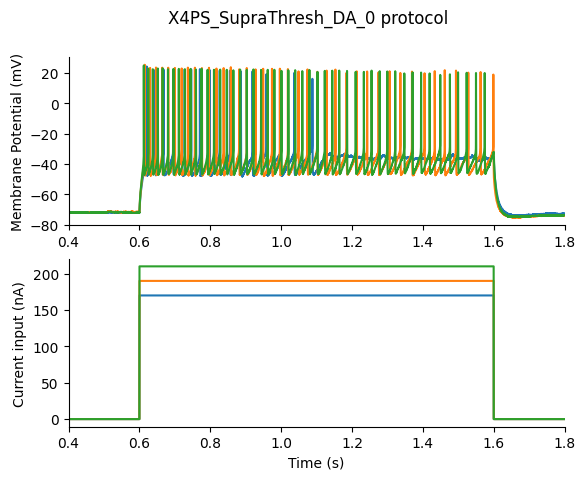

In [9]:
desired_protocol = 'X4PS_SupraThresh_DA_0'
fig, axs = plt.subplots(2,1)
with fs.open(s3_url, "rb") as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read() # required to open file
            p_sweeps_ind = protocol_sweeps_ids[desired_protocol] # indices of sweeps belonging to protocol
            for sweep in p_sweeps_ind: #for each sweep in protocol
                num_samples = nwbfile.stimulus.get(sweep_list[sweep[0]]).num_samples # length of sweep
                samp_rate = nwbfile.stimulus.get(sweep_list[sweep[0]]).rate # sample rate

                # get time, voltage and current input of the sweep
                t = np.arange(0, num_samples, 1) * (1 / samp_rate)
                V = nwbfile.acquisition.get(acq_list[sweep[0]]).data[:]
                I = nwbfile.stimulus.get(sweep_list[sweep[0]]).data[:]

                # plot the voltage traces and current inputs for the sweep
                axs[0].plot(t, V)
                axs[1].plot(t, I)

# label plot and set x limits
xlim = (0.4, 1.8)
axs[0].set_xlim(xlim)
axs[0].set_ylabel('Membrane Potential (mV)')
axs[1].set_xlim(xlim)
axs[1].set_ylabel('Current input (nA)')
axs[1].set_xlabel('Time (s)')
for ax in axs.reshape(-1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.suptitle('{} protocol'.format(desired_protocol))
plt.show()

# 2. Electrophysiological Features and Feature Extraction Packages
Qualitative features of neuron firing (bursting, spike frequency adaptation, rebound spiking)

Extract electrophysiological features using Blue Brain Project [Electrophys Feature Extraction Library eFEL](https://efel.readthedocs.io/en/latest/index.html)

Description of all [eFEL features](https://efel.readthedocs.io/en/latest/eFeatures.html)

In [10]:
import efel
efel_feat = efel.getFeatureNames()

efel_feat = ['AP_amplitude','AP_duration','AP_height', 'AP_width', 'ISI_CV', 'ISI_values', 'Spikecount', 'Spikecount_stimint',
 'adaptation_index', 'adaptation_index2', 'irregularity_index', 'mean_frequency',  'spike_half_width','spike_width2', 'peak_indices','all_ISI_values']

trace1 = {} # A 'trace' is a dictionary for input into efel feature extraction
desired_sweep = 0
with fs.open(s3_url, "rb") as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read() # required to open file
            p_sweeps_ind = protocol_sweeps_ids[desired_protocol] # indices of sweeps belonging to protocol
            sweep = p_sweeps_ind[desired_sweep]
            num_samples = nwbfile.stimulus.get(sweep_list[sweep[0]]).num_samples # length of sweep
            samp_rate = nwbfile.stimulus.get(sweep_list[sweep[0]]).rate # sample rate
            t = np.arange(0, num_samples, 1) * (1 / samp_rate)
            V = nwbfile.acquisition.get(acq_list[sweep[0]]).data[:]
            I = nwbfile.stimulus.get(sweep_list[sweep[0]])
            trace1['T'] = t # Set the 'T' (=time) key of the trace
            trace1['V'] = V # Set the 'V' (=voltage) key of the trace
            trace1['stim_start'] = [0.6] # Set the 'stim_start' (time at which a stimulus starts, in ms) # must be a list (with one element)
            trace1['stim_end'] = [1.6] # Set the 'stim_end' (time at which a stimulus end) key of the trace # must be a list (with one element)

# Multiple traces can be passed to the eFEL at the same time, so the argument should be a list
traces = [trace1]

# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 1/samp_rate)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

# extract features
traces_results = efel.getFeatureValues(traces, efel_feat, raise_warnings=False)

# print results of efel feature extraction
for c in traces_results:
    for key in c:
        print(key)
        print(c[key], "\n")

AP_amplitude
[96.15624999 69.76249694 69.53124808 69.20624923 69.16874694 70.03749656
 69.89374922 69.66875075 69.37499999 68.29374883 68.00625037 68.9624977
 66.66875075 66.49374962 67.05624961 63.03125   ] 

AP_duration
[0.02196 0.02426 0.02282 0.0267  0.02608 0.02472 0.02428 0.02744 0.0284
 0.02852 0.0306  0.03186 0.03868 0.03982 0.03802 0.05068] 

AP_height
[24.15624999 21.89374923 22.13749885 21.76874923 22.33124923 22.26249885
 22.40624998 21.87499999 21.58124923 21.41250036 20.80624961 20.99999999
 19.12499998 19.35000038 19.88749885 16.03125   ] 

AP_width
[0.0005  0.00054 0.00056 0.00054 0.00056 0.00056 0.00054 0.00056 0.00056
 0.00056 0.00058 0.00058 0.0006  0.0006  0.0006  0.00068] 

ISI_CV
[0.25136503] 

ISI_values
[0.02428 0.02318 0.02718 0.02578 0.02516 0.02468 0.02734 0.02868 0.02874
 0.03084 0.03304 0.03938 0.03978 0.03846 0.05118] 

Spikecount
[16] 

Spikecount_stimint
[16] 

adaptation_index
[0.02626468] 

adaptation_index2
[0.03035417] 

irregularity_index
[0.0024493

Plot the sweep with detected APs

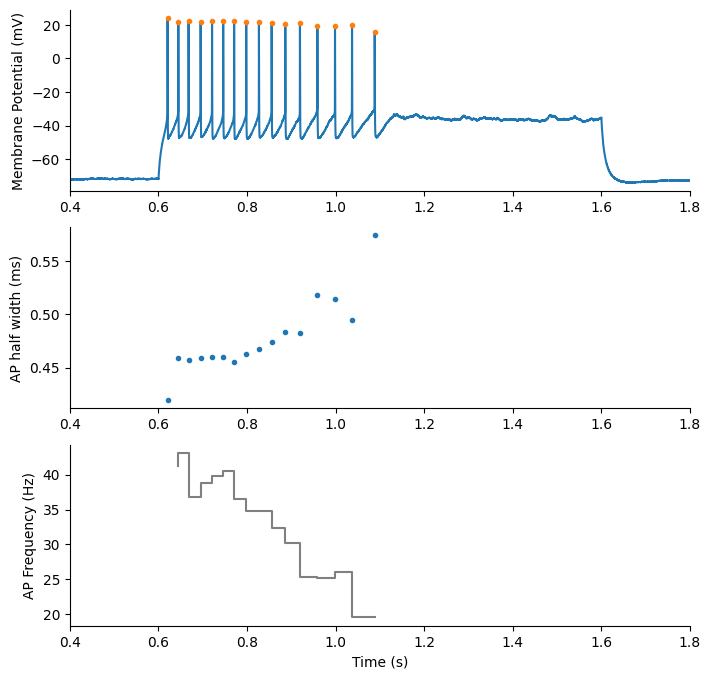

In [11]:
fig, axs = plt.subplots(3,1, figsize=(8,8))
axs[0].plot(t, V) # plot voltae trace
axs[0].plot(t[traces_results[0]['peak_indices']], traces_results[0]['AP_height'], '.') # plot peaks
axs[0].set_xlim(xlim)
axs[0].set_ylabel('Membrane Potential (mV)')


axs[1].plot(t[traces_results[0]['peak_indices']], traces_results[0]['spike_half_width']*1000, '.') # plot peaks
axs[1].set_ylabel('AP half width (ms)')
axs[1].set_xlim(xlim)


axs[2].step(t[traces_results[0]['peak_indices']][1:], 1/traces_results[0]['all_ISI_values'],'grey', where='pre') # plot voltae trace
axs[2].set_xlim(xlim)
axs[2].set_ylabel('AP Frequency (Hz)')
axs[2].set_xlabel('Time (s)')

# remove top and right plot borders
for ax in axs.reshape(-1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()


# 3. Izhekevich Model

$$ dV_m/dt = 0.04 V_m^2 + 5 V_m + 140 - u + I $$
$$ du/dt = a (b V_m - u)$$
if $Vm≥Vth$: then $V_m \leftarrow c$, $u \leftarrow u + d$

| Variable | Units   | Description                               |
|----------|---------|-------------------------------------------|
| $V_m$    | mV      | Membrane potential                        |
| $U_m$    | mV      | Membrane potential recovery variable      |
| $V_{th}$ | mV      | Spike threshold                           |
| $I_e$    | nA      | Constant input current (R=1)              |
| a        | real    | Describes time scale of recovery variable |
| b        | real    | Sensitivity of recovery variable          |
| c        | mV      | After-spike reset value of $V_m$          |
| d        | mV      | After-spike reset value of $U_m$          |

# 4. Assignment: Use Forward Euler method to simulate the Izhekevich model [NB]

# 5. Assignment: Fit the parameters of your Izhekevich model (a,b,c,d) to fit this spike train [NB]